In [1]:
import pickle
import PIL, torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from torchvision import models
from torch import nn
import pandas as pd

if torch.cuda.is_available() == True:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device)
dtype = torch.float32

OCC_ONLY = Path('/home/florian/dev/ET-Adversarials/data/Occ_only_226px/')
IMGS = Path('/home/florian/dev/ET-Adversarials/data/scaled images/')

torch.cuda.set_per_process_memory_fraction(.2,0)

cuda:0


# Extract Labels

In [2]:
labels = []
for i,f in enumerate(list(sorted(IMGS.iterdir()))):
    labels.append(int(f.name[-6]))
labels = torch.Tensor(labels).to(device)

In [3]:
classses = {
    0:'fish',
    1:'dog',
    2:'cassette player',
    3:'chainsaw',
    4:'church',
    5:'music instrument',
    6:'garbage truck',
    7:'gas',
    8:'golfball',
    9:'parachute',
}

### Load Image and Heat Map with PIL

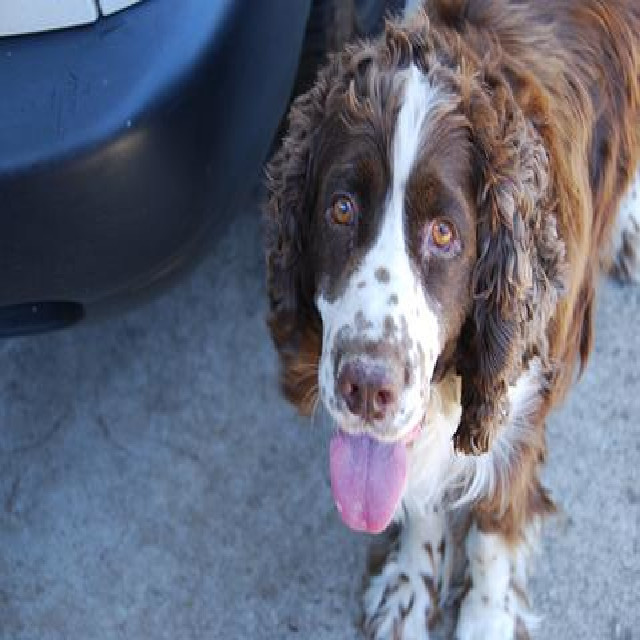

In [4]:
ex_img = list(sorted(IMGS.iterdir()))[0]
ex_img = PIL.Image.open(ex_img);ex_img # Eye-Tracking Map

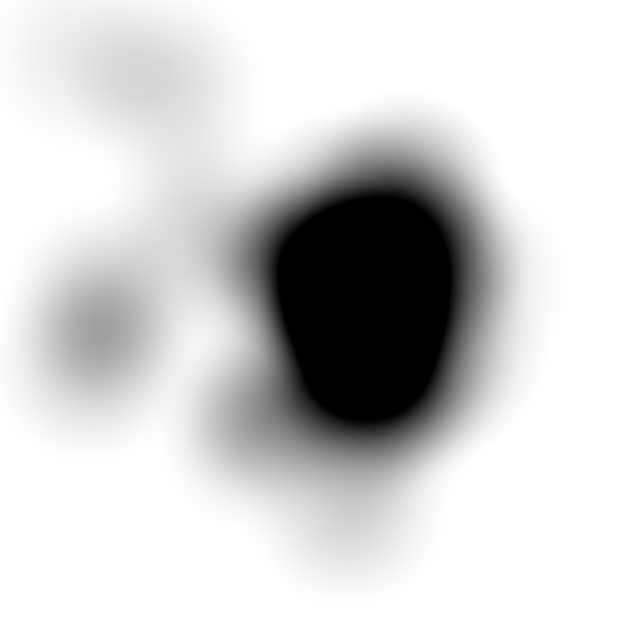

In [5]:
ex_map = list(sorted(OCC_ONLY.iterdir()))[0]
ex_map = PIL.Image.open(ex_map);ex_map # Eye-Tracking Map
#This is what we get from Tobii

### Resize and Normalize Heat Map

In [6]:
def process_maps(etm):
    etm = etm.resize((224,224))
    x = np.asarray(etm)
    x = np.transpose(x, (2,0,1))[3]/255
    return np.expand_dims(x, axis=0)

etm = process_maps(ex_map)

#test if map is in valid range of 0 and 1
assert etm.max() <= 1
assert etm.min() >= 0
#test if map has one channel and target size of 224
assert etm.shape ==(1,224,224)

def process_imgs(img):
    img = img.resize((224,224))
    x = np.asarray(img)
    if len(x.shape) != 3:
        x = np.expand_dims(x,2)
        x = np.concatenate((x,x,x),2)
    x = np.transpose(x, (2,0,1))/255
    return x

#test if processing works for 3 channel images
img = process_imgs(ex_img)
#test if image is in valid range of 0 and 1
assert img.max() <= 1
assert img.min() >= 0
#test if final image has 3 channels and target size of 224
assert img.shape ==(3,224,224)

#test if processing works for 1 channel b/w images (that occur in the imagenette dataset)
test_bw_img = PIL.Image.fromarray(np.uint8(np.random.rand(224,224)*255))
img = process_imgs(test_bw_img)
#test if image is in valid range of 0 and 1
assert img.max() <= 1
assert img.min() >= 0
#test if final image has 3 channels and target size of 224
assert img.shape ==(3,224,224)

## Construct Image and Heatmap Batches

In [7]:
img_batch = torch.empty((0,3,224,224))
etm_batch = torch.empty((0,1,224,224))

In [8]:
for img, mask in zip(sorted(IMGS.iterdir()), sorted(OCC_ONLY.iterdir())):
    img = PIL.Image.open(img)
    img = process_imgs(img)
    
    etm = process_maps(PIL.Image.open(mask))
    etm_batch = torch.cat((etm_batch,torch.Tensor(etm).unsqueeze(0)))
    img_batch = torch.cat((img_batch,torch.Tensor(img).unsqueeze(0)))

In [9]:
img_batch = img_batch.to(device)
etm_batch = etm_batch.to(device)

In [10]:
assert img_batch.shape[1:] == (3,224,224) #check that img batch has format (NCHW)

## Load Model

In [11]:
#utils
def batch_accuracy(x,y): return round(((model(x).argmax(1)==y).sum()/x.shape[0]).item(), 4)

class ImageNetNormalization(nn.Module):
    def __init__(self, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        super(ImageNetNormalization, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, x):
        return torchvision.transforms.functional.normalize(x, self.mean, self.std)

###### Resnet

In [12]:
base_resnet = models.resnet18(pretrained=True)

num_ftrs_in = base_resnet.fc.in_features
num_ftrs_out = 10
base_resnet.fc = nn.Linear(num_ftrs_in, num_ftrs_out)
resnet = torch.nn.Sequential(
    ImageNetNormalization(),
    base_resnet
)

MODEL_PATH = './models/ResNet18.pt'
state_dict = torch.load(MODEL_PATH)
resnet.load_state_dict(state_dict)
resnet = resnet.to(device)
model = resnet
model.eval()
batch_accuracy(img_batch, labels)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.75 GiB total capacity; 137.61 MiB already allocated; 7.38 MiB free; 2.15 GiB allowed; 146.00 MiB reserved in total by PyTorch)

###### MobileNet V3 Small

In [13]:
base_mobilenet = models.mobilenet_v3_small(pretrained=True)

num_ftrs_in = base_mobilenet.classifier[0].in_features
num_ftrs_out = base_mobilenet.classifier[0].out_features
base_mobilenet.classifier[0] = nn.Linear(num_ftrs_in, num_ftrs_out)

num_ftrs_in = base_mobilenet.classifier[3].in_features
num_ftrs_out = 10
base_mobilenet.classifier[3] = nn.Linear(num_ftrs_in, num_ftrs_out)

mobilenet = torch.nn.Sequential(
    ImageNetNormalization(),
    base_mobilenet
)

MODEL_PATH = './models/MobileNetV3Small.pt'
state_dict = torch.load(MODEL_PATH)
mobilenet.load_state_dict(state_dict)
mobilenet = mobilenet.to(device)
model = mobilenet
model.eval()
batch_accuracy(img_batch, labels)


1.0

## Attacks

### Eye-tracking data aware Carlini Wagner L2 Attack

In [22]:
def classification_loss(Z,x,t):
    logits = Z(x)[0]
    if logits.argmax() == t:
        loss = torch.nn.functional.relu(logits[logits.argsort(descending=True)[1]] - logits[t])
    else:
        loss = torch.nn.functional.relu(logits[logits.argmax()] - logits[t])
    return loss

def classification_loss(logits,t):
    if logits.argmax() == t:
        loss = torch.nn.functional.relu(logits[logits.argsort(descending=True)[1]] - logits[t])
    else:
        loss = torch.nn.functional.relu(logits[logits.argmax()] - logits[t])
    return loss

'''
    This is the loss term added to the original C&W term. It is the product of delta_i and 
    the eye-tracking-value of pixel i. As such, the loss is high for high delta and eye-tracking values, 
    but low otherwise. Effectively incentivizing the algorithm to find perturbations outside the area 
    humans spend most time when evaluating the image.
'''
def hpa_loss(w,x,et_map):
    delta = 0.5 * (torch.tanh(w) + 1) - x
    return (delta * et_map).norm()

def loss_fn(w,x, logits, et_map, target, verbose=False):
    loss1 = torch.sqrt(torch.norm((.5*(torch.tanh(w) + 1)) - x ))
    loss2 = classification_loss(logits ,target)
    loss3 = hpa_loss(w,x,et_map)
    if verbose == True: print('loss 1:', loss1.item(), ' -- loss 2:',loss2.item(), ' -- loss 3:',loss3.item())
    return loss1, loss2, loss3

def sgd_cw_l2_attack(model, x, et_map, target, loss_fn, iterations, w_initialization='zeros', c=.1,d=.5, lr=10):
    if w_initialization == 'zeros': w = torch.zeros_like(x).requires_grad_(True)
    if w_initialization == 'rand': w = torch.rand_like(x).requires_grad_(True)
    if w_initialization == 'randn': w = (torch.randn_like(x)/4).requires_grad_(True)
    
    stats = pd.DataFrame(columns=['i', 'loss'])
    best_adv = {
        'total-loss':1000
    }
    
    w.requires_grad_(True)
    criterion = loss_fn
    for i in range(iterations):
        if i%50==0:
            print('iteration:', i)
            loss1,loss2,loss3 = criterion(w,x,logits,et_map,target,verbose=True)
        else:
            loss1,loss2,loss3 = criterion(w,x,logits,et_map,target)
        loss = loss1 + c * loss2 + d * loss3
#       print(loss)
        loss.backward(retain_graph=True)
        if loss < best_adv['total-loss']:
            best_adv = {
                'l2-loss': loss1,
                'classification-loss': loss2,
                'human-perception-loss': loss3,
                'total-loss':loss,
                'adv': .5 * (torch.tanh(w)+1),
                'w': w,
                'iteration': i,
                'prediction':model(.5 * (torch.tanh(w)+1).unsqueeze(0)).argmax()
            }
        grads = w.grad
        w = w - lr * grads
        w.retain_grad()
        stats = stats.append(pd.Series({'i':i, 'loss':loss.item()}), ignore_index=True)
        
    return best_adv, stats

def pt_optim_cw_l2_attack(model, x, et_map, target, loss_fn, iterations, w_initialization='zeros', C=[1e-4,1e-3,1e-2,1e-1,1] ,D=[0.05,.1,.5], optim=torch.optim.Adam, lr=.01, verbose=False):
    if w_initialization == 'zeros': w = torch.zeros_like(x).requires_grad_(True)
    if w_initialization == 'rand': w = torch.rand_like(x).requires_grad_(True)
    if w_initialization == 'randn': w = (torch.randn_like(x)/4).requires_grad_(True)
    stats = pd.DataFrame(columns=['i', 'loss'])
    best_adv = {
        'total-loss':1000
    }
    w.requires_grad_(True)
    
    optimizer = optim([w],lr=lr)
    criterion = loss_fn
    
    for c in C:
        for d in D:
            for i in range(iterations):
                optimizer.zero_grad()
                adv = .5 * (torch.tanh(w)+1)
                logits = model(adv.unsqueeze(0))[0]
                pred = logits.argmax(-1)
                #print(target)
                if verbose==True and i%200==0: print('iteration:', i)
                loss1,loss2,loss3 = criterion(w,x,logits,et_map,target,verbose=verbose)
                loss = loss1 + c * loss2 + d * loss3
        #       print(loss)
                
                if loss1+10*loss2+loss3 < best_adv['total-loss'] and pred==target:
                    best_adv = {
                        'l2-loss': loss1,
                        'classification-loss': loss2,
                        'human-perception-loss': loss3,
                        'total-loss':loss1+10*loss2+loss3,
                        'adv': adv,
                        'c': c,
                        'd': d,
                        'w': w,
                        'iteration': i,
                        'prediction':pred
                    }
                loss.backward(retain_graph=True)
                optimizer.step()
                stats = stats.append(pd.Series({'i':i, 'loss':loss.item()}), ignore_index=True)
        c = c*10
    return best_adv, stats


def get_targets(model, img_batch, gt_labels):
    targets = list()
    logits = model(img_batch)
    for i,pred in enumerate(logits):
        if pred.argmax()==gt_labels[i]:
            targets.append(pred.argsort(descending=True)[1])
        else: targets.append(pred.argmax())
    return(torch.Tensor(targets))

targets = get_targets(model, img_batch.to(device), labels)

x = img_batch[0]
et_map = etm_batch[0]

# Single Attack

In [ ]:
pt_sgd_best_adv,_ = pt_optim_cw_l2_attack(
    model, x,et_map,0, loss_fn, 3000, w_initialization='zeros', optim=torch.optim.SGD, lr=10
)

pt_adam_best_adv,_ = pt_optim_cw_l2_attack(
    model, x,et_map,3, loss_fn, 5000, w_initialization='zeros', optim=torch.optim.Adam, lr=.01
)

sgd_best_adv,_ = sgd_cw_l2_attack(
    model, x,et_map,0, loss_fn, 5000, w_initialization='zeros', lr=10
)

In [105]:
sgd_best_adv['iteration'], pt_sgd_best_adv['iteration'], pt_adam_best_adv['iteration']

(2936, 497, 3964)

In [99]:
sgd_adv = sgd_best_adv['adv']
sgd_delta = (sgd_adv-x)*50+.5
pt_sgd_adv = pt_sgd_best_adv['adv']
pt_sgd_delta = (pt_sgd_adv-x)*50+.5
pt_adam_adv = pt_adam_best_adv['adv']
pt_adam_delta = (pt_adam_adv-x)*50+.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'l2-loss: 1.02996027469635| hp-loss: 0.1961529552936554')

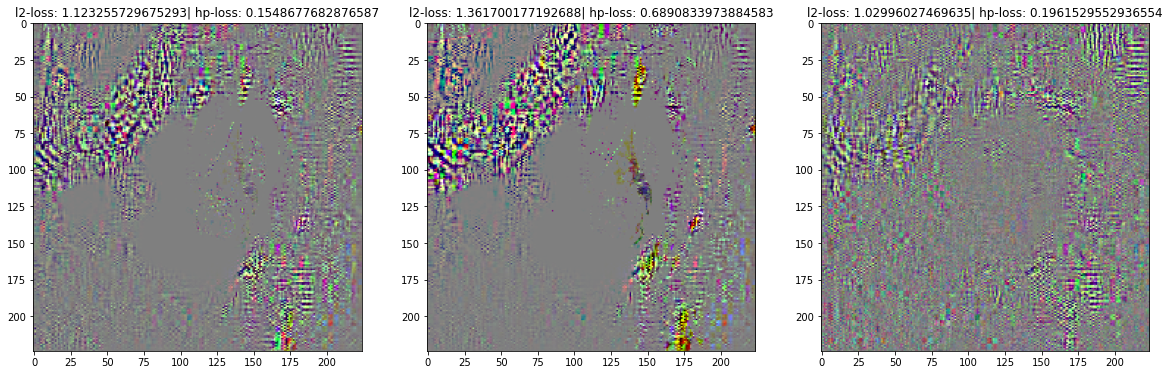

In [101]:
fig, axes = plt.subplots(1,4, figsize=(20,10))
axes = axes.flatten()
axes[0].imshow(et_map.detach().cpu().squeeze())
axes[1].imshow(sgd_delta.detach().cpu().permute(1,2,0))
axes[1].set_title('l2-loss: '+str(sgd_best_adv['l2-loss'].item()) + '| hp-loss: ' +str(sgd_best_adv['human-perception-loss'].item()))
axes[2].imshow(pt_sgd_delta.detach().cpu().permute(1,2,0))
axes[2].set_title('l2-loss: '+str(pt_sgd_best_adv['l2-loss'].item()) + '| hp-loss: ' +str(pt_sgd_best_adv['human-perception-loss'].item()))
axes[3].imshow(pt_adam_delta.detach().cpu().permute(1,2,0))
axes[3].set_title('l2-loss: '+str(pt_adam_best_adv['l2-loss'].item()) + '| hp-loss: ' +str(pt_adam_best_adv['human-perception-loss'].item()))

# Batch attack

In [23]:
C = [1e-4 * 10** x for x in range(9)]
targets = get_targets(model, img_batch, labels).int()
advs = []
for i, (x,et_map,target) in enumerate(zip(img_batch, etm_batch, targets)):
    print('----------', i,'---------')
    best_adv,_ = pt_optim_cw_l2_attack(
        model, 
        x,
        et_map,
        target, 
        loss_fn=loss_fn, 
        iterations=10000, 
        C=C,
        lr=.01
    )
    advs.append(best_adv)

    with open('et-aware-advs-w-fb-params.pkl', 'wb') as handle:
        pickle.dump(advs, handle, protocol=pickle.HIGHEST_PROTOCOL)

---------- 0 ---------
---------- 1 ---------
---------- 2 ---------
---------- 3 ---------
---------- 4 ---------
---------- 5 ---------
---------- 6 ---------
---------- 7 ---------
---------- 8 ---------
---------- 9 ---------
---------- 10 ---------
---------- 11 ---------
---------- 12 ---------
---------- 13 ---------
---------- 14 ---------
---------- 15 ---------
---------- 16 ---------
---------- 17 ---------
---------- 18 ---------
---------- 19 ---------
---------- 20 ---------
---------- 21 ---------
---------- 22 ---------
---------- 23 ---------
---------- 24 ---------
---------- 25 ---------
---------- 26 ---------
---------- 27 ---------
---------- 28 ---------
---------- 29 ---------
---------- 30 ---------
---------- 31 ---------
---------- 32 ---------
---------- 33 ---------
---------- 34 ---------
---------- 35 ---------
---------- 36 ---------
---------- 37 ---------
---------- 38 ---------
---------- 39 ---------
---------- 40 ---------
---------- 41 ---------
--

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 10.75 GiB total capacity; 1.27 GiB already allocated; 6.38 MiB free; 2.15 GiB allowed; 1.31 GiB reserved in total by PyTorch)

In [34]:
for adv in advs:
    print(adv['c'], adv['d'])
    print(adv['l2-loss'].item(), adv['human-perception-loss'].item()) 

0.05 0.1
0.5973902344703674 0.1949443221092224
0.05 0.1
0.4136878252029419 0.06312961131334305
0.05 0.1
0.5550186038017273 0.10829663276672363
0.05 0.1
0.5501686334609985 0.24578148126602173
0.05 0.5
0.5613906383514404 0.0629352405667305
0.05 0.3
0.6237107515335083 0.09011663496494293
0.05 0.1
0.534443199634552 0.19287508726119995
0.05 0.5
0.5288427472114563 0.05861704796552658
0.05 0.3
0.9677673578262329 0.27324917912483215
0.05 0.5
0.676454484462738 0.08819185942411423
0.05 0.3
0.3999019265174866 0.05784783884882927
0.5 0.5
0.787979006767273 0.042539313435554504
0.05 0.3
0.9199478030204773 0.15739785134792328
0.05 0.3
1.0143412351608276 0.126170352101326
0.05 0.1
0.33498629927635193 0.035230688750743866
0.05 0.1
0.4432419538497925 0.04305967316031456
0.05 0.1
0.5482878088951111 0.11056645214557648
0.05 0.1
0.3983692526817322 0.0775250717997551
0.05 0.1
0.5779023766517639 0.145494282245636
0.05 0.1
0.6053535342216492 0.158028706908226
0.05 0.3
0.23458023369312286 0.015155639499425888


In [44]:
advs_raw = []
for adv in advs:
    advs_raw.append(adv['adv'])
advs_raw = torch.stack(advs_raw)
model.eval()
assert batch_accuracy(advs_raw, labels) == 0.0

In [ ]:
def viz(inp):
    plt.imshow((inp).detach().cpu().permute(1,2,0))
def viz_etm(inp):
    plt.imshow(inp.detach().cpu().permute(1,2,0))
def viz_pert(inp):
    plt.imshow((inp+0.5).detach().cpu().permute(1,2,0))

In [ ]:
viz_etm(etm_batch[0])

In [ ]:
print(perturbation.min())
viz_pert(perturbation[0])

In [ ]:
viz(adv_examples[0])

In [ ]:
viz_pert(hpa_perturbation[0])

In [ ]:
viz(hpa_adv_examples[0])

In [ ]:
import foolbox
from foolbox.attacks import PGD, FGSM

attack = FGSM()

img_batch.requires_grad_(False)
model.eval()
fmodel = foolbox.PyTorchModel(
    model.to(device), 
    bounds=(0,1), 
    #preprocessing=dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
)
raw_advs, clipped_advs, success = attack(
    fmodel, 
    img_batch.to(device), 
    criterion=labels.long().to(device), 
    epsilons=[8/255]
)

clipped_advs